In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install imutils
!pip install efficientnet_pytorch

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=86fa44df3e57b3961e27b322b651604c3d3e17ce3b32d23f52efb855ca4d261f
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=0718c12a7ea6e36c91bacc4c269e6ab136a53a8789dda5bb4e2acd4270c4ba77
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


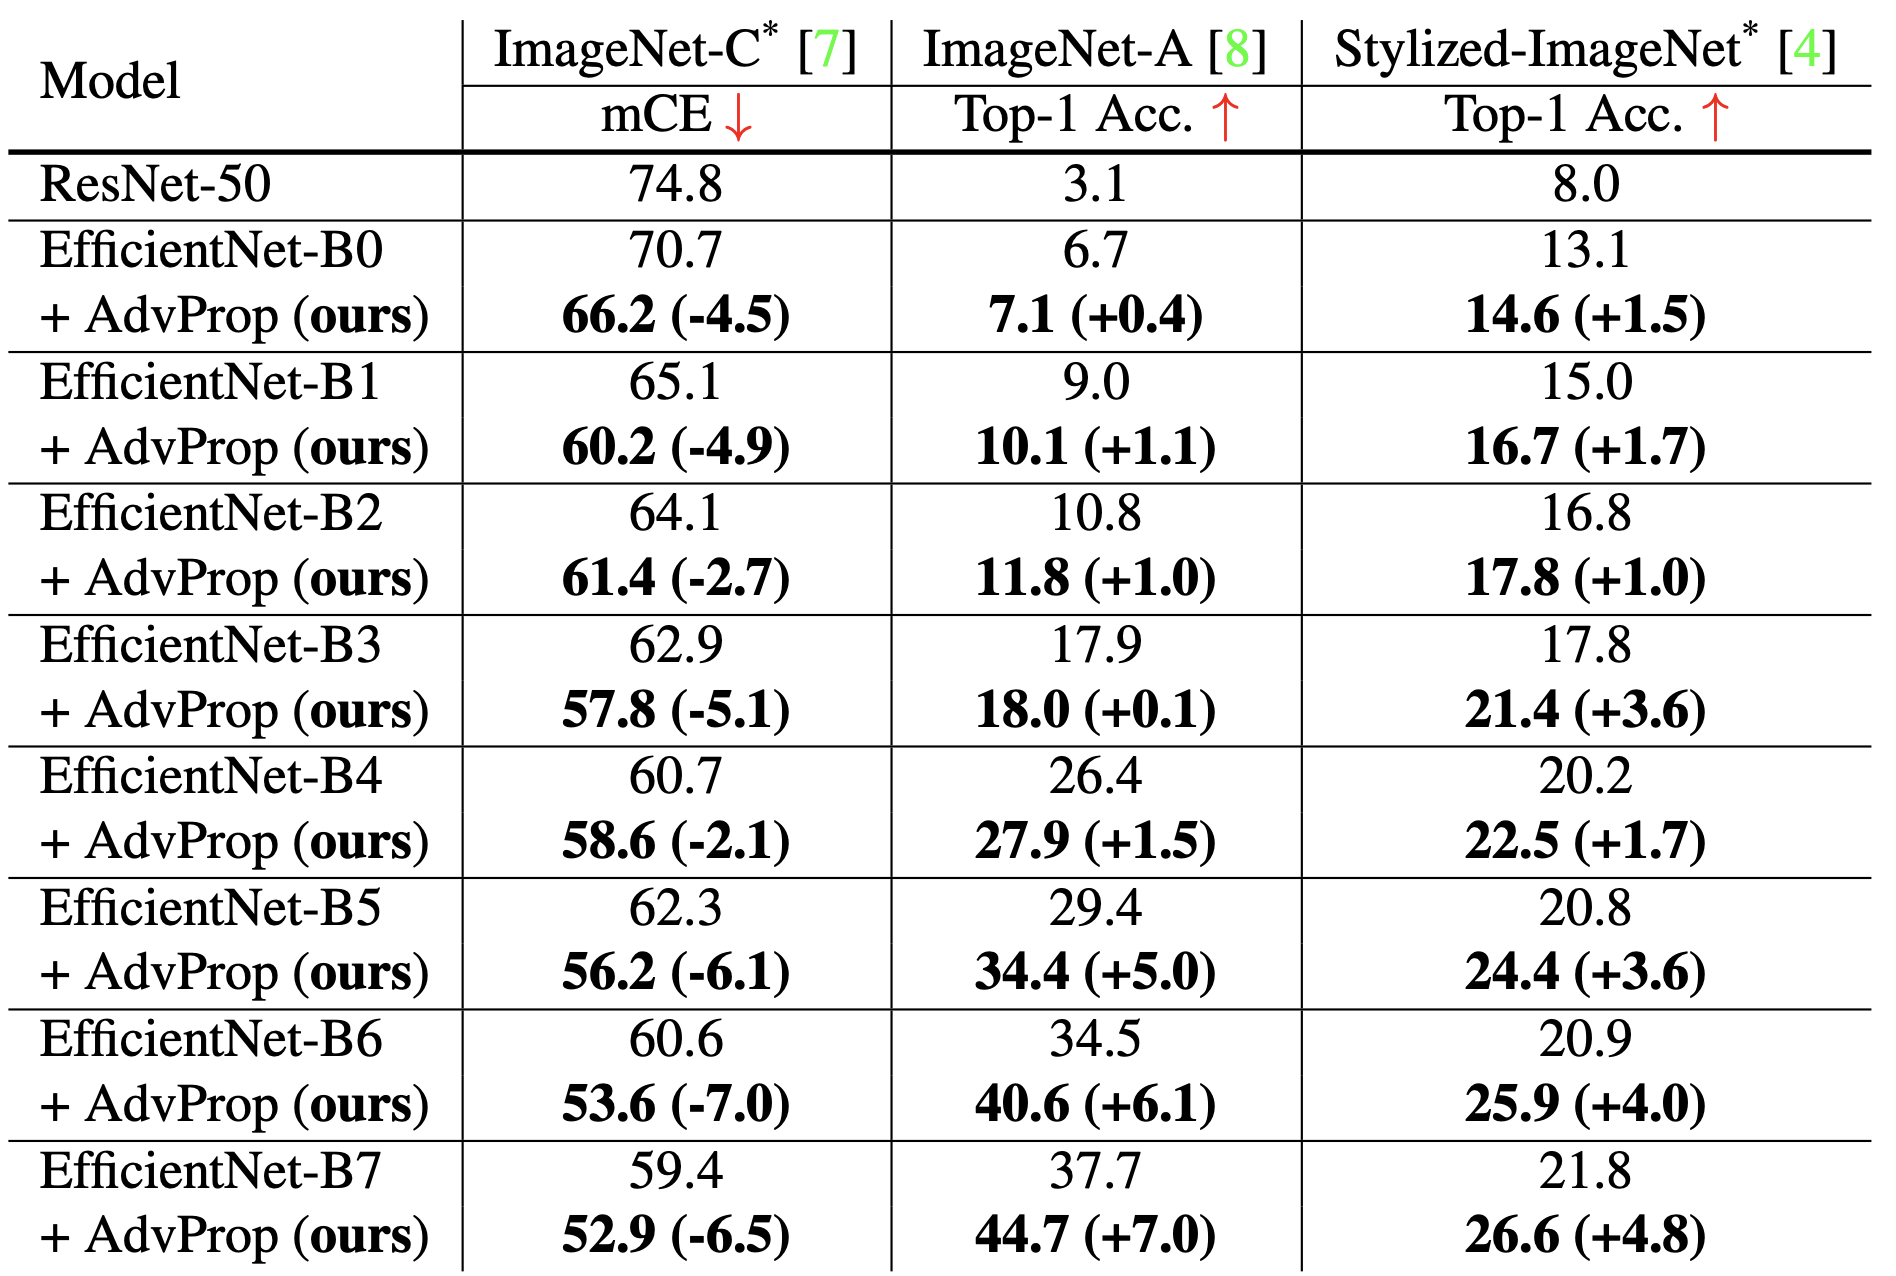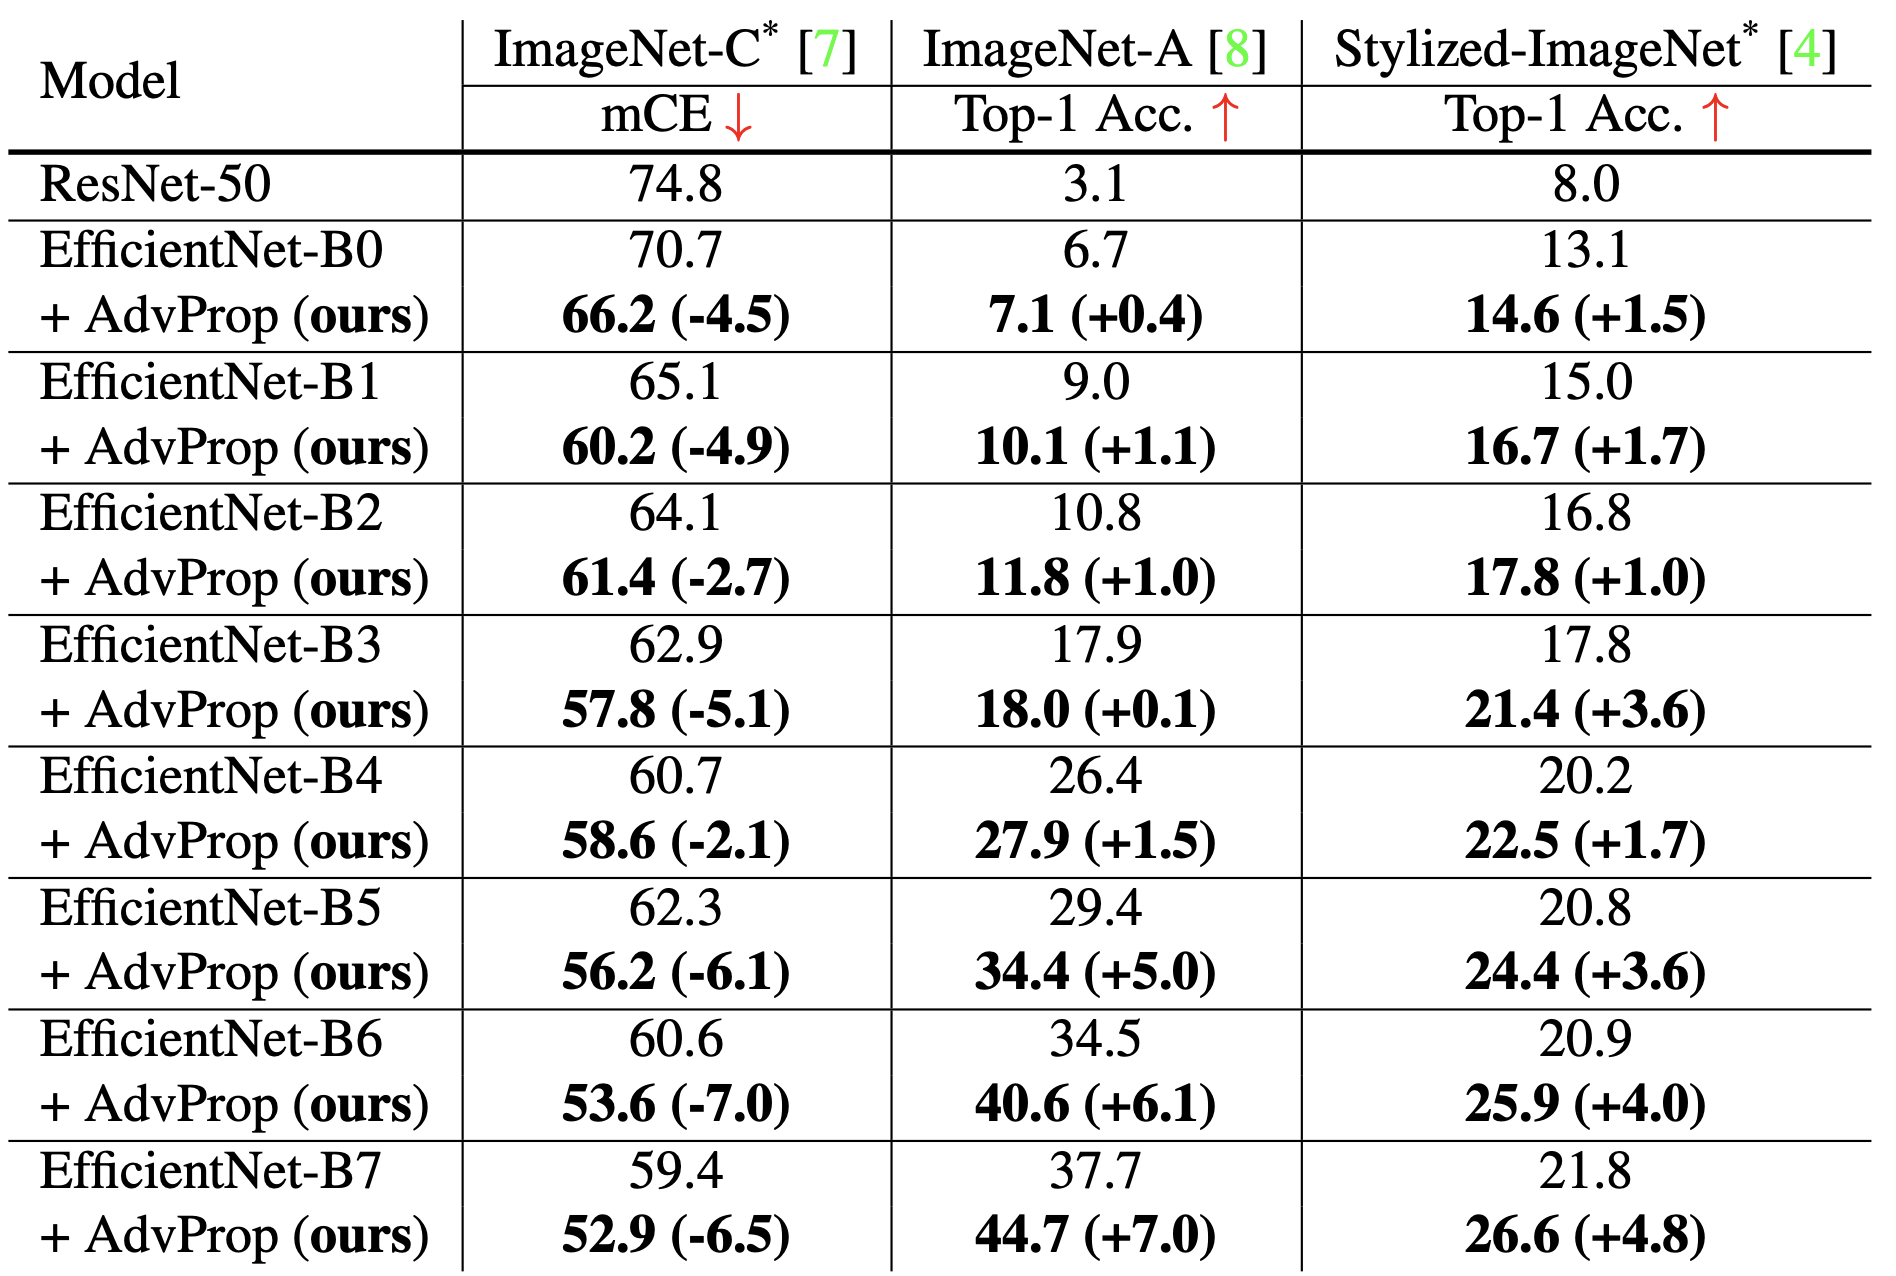

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import imutils
import zipfile
import os, random
from PIL import Image
from datetime import datetime
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models # 사전에 구성된 다양한 모델 제공, pretrained 여부 결정 가능
import torchvision.transforms as T 
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter # 텐서보드로 시각화가 가능하게 log를 남겨줌
from torch.autograd import Variable # 텐서를 감싸는 클래스, backward로 자동미분가능

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# from models.rexnet import ReXNetV1
from efficientnet_pytorch import EfficientNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 디바이스 설정

# 처음보는 패키지 정리
imutils: opencv가 가진 복잡함을 조금이나마 해소해주기 위한 패키지인듯

albumentations: 이미지 증식에 사용되는 파이썬 라이브러리, 간단하고 통일된 API를 제공, 빠른 속도, 70가지 이상의 다양한 증식방법, pytorch 생태계의 일부이긴 하지만 tensorflow도 사용 가능



In [5]:
# Set seed
# 모든 패키지의 random seed를 고정시켜준다.
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.daterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [6]:
# Configs
# f-string 포맷팅을 편하게 해준다.
# 예) f'Hi my name is {name}'
BASE_PATH  = f'../../Datasets/dacon_CV_competition_2_ver2'
PRETRAINED = f'./ checkpoints/pretrained/rexnetv1_2.0x.pth'
LOG_PATH = f'./logs'

MODEL_NAME = "efficientnet_b6"
MODE = 'dirty'
n_splits = 5
EPOCHS = 200

early_stop=10
lr = 1e-3
num_workers=6
batch_size = 15

current_time = datetime.now().strftime('%Y%M%D-%H-%M-%S')

LOG_NAME = f'{MODE}_{MODEL_NAME}_batch_{batch_size}_lr_{lr}_{current_time}_Augmentation_label_smoothing'

SyntaxError: EOL while scanning string literal (<ipython-input-6-063244939d3d>, line 20)

# Load Data

In [ ]:
# albumentations 정리
# import albumentations as A
# from albumentations.pytorch.transforms import ToTensorV2



dirty_mnist_answer = pd.read_csv(f"{BASE_PATH}dirty_mnist_2nd_answer.csv")

namelist = os.listdir(f"{BASE_PATH}{MODE}_mnist/")


# p의 의미: augmentation의 적용 여부를 설정
# always_apply = True
# p=1.0으로 하면 되는데 always_apply를 쓰는 이유는?
# parent container도 p값을 갖고, 각 augmentation들도 p값을 갖기 때문에
# 부모 컨테이너가 죽어버리면 그 아래의 augmentation들도 죽어버림
# 하지만 자식 augmentation의 always_apply를 적용시키면 부모의 확률과 관계없이 해당 augmentation은 무조건 적용
to_tensor_val = A.Compose([
    ToTensorV2(p=1.0)
])

to_tensor = A.Compose([
    A.Rotate(p=0.5),
    A.RandomContrast(p=0.5),
    A.Cutout(p=0.5),
    ToTensorV2(p=1.0),
])

class DatasetMNIST(torch.utils.data.Dataset):
    def __init__(self,
                dir_path,
                meta_df,
                transforms = to_tensor, #미리 선언한 to_tensor를 transforms로 받음
                 augmentation=None,
                 train_flag = False): # train상태인지 아닌지를 알려줌, dropout등을 쓰면 안 되니까
        self.dir_path = dir_path
        self.meat_df = meat_df
        self.train_flag = train_flag
        self.transforms  = transforms # Transform
        self.augmentations = augmentations # Augmentation
        
    def __len__(self):
        return len(self.meta_df)
    
    def __getitem__(self,index):
        # 폴더경로 + 이미지 이름 + .png -> 파일의 경로
        # 문자열.zfill(5) : 빈 자리를 0으로 채워준다
        # 예) "3".zfill(3) == "003"
        
        # cv2.IMREAD_GRAYSCALE: png파일을 채널이 1개인 GRAYSCALE로 읽음
        image = cv2.imread(self.dir_path + \
                           str(self.meta_df.iloc[index,0]).zfill(5)+'.png',
                              cv2.IMREAD_GRAYSCALE)
        # 0~255의 값을 갖고 크기가 256,256인 np array를
        # 0~1의 값의 실수를 갖고 ,크기가 256,256,1인 np array로 변환
        image = (iamge/255).astype('float')[...,np.newaxis]
        
        # 정답 array 생성, 존재하면 1, 아니면 0
        label = self.meta_df.iloc[index,1:].values.astype('float')
        if self.train_flag:
            label = label*0.9 + 0.1/26
            
        sample = {'image':image,'label':label}
        
        return sample

# Define Model

In [ ]:
class MultiLabelResnet(nn.Module):
    def __init__(self):
        super(MultiLabelResnet,self).__init__()
        self.conv2d = nn.Conv2d(1,3,3, stride = 1)
        
        self.backbone = EfficientNet.from_pretrained('efficient-b6',include_top=True)
        
        self.out_features = self.backbone._fc.in_features
        
        self.conv = nn.Conv2d(self.out_features,26,1,bias=False)
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        
        # 입력층
        x = F.relu(self.conv2d(x))
        
        # efficientnet
        x = F.relu(self.backbone(x))
        x = self.conv(x)
        
        # 출력층
        x = torch.sigmoid(self.flatten(x))
        return x

# Training

In [ ]:
# cross validation을 적용하기 위한 KFold
from sklearn.model_selection import KFold
fkold = KFold(n_splits=n_splits, shuffle=True, random_state=0)

# dirty_mnist_answer에서 train_idx와 val_idx를 생성
best_models = []
for fold_index,(trn_idx, val_idx) in enumerate(kflod.split(dirty_minst_answer),1):
    ### 
    if fold_index != 5:continue
    print(f'[fold:{fold_index}]')
    writer = SummaryWriter('{LOG_PATH}/fold_{fold_index}_{MODE}_{LOG_NAME}')
    # cuda cache 초기화
    torch.cuda.empty_cache()
    
    # train fold, validation_fold 분할
    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]
    
    #Dataset 정의
    train_dataset = DatasetMNIST("{BASE_PATH}{MODE}_mnist/",train_answer,train_flag=True)
    valid_dataset = DatasetMNIST("{BASE_PATH}{MODE}_mnist/",test_answer,transforms=to_tensor_val)
    
    # DataLoader 정의
    train_data_loader = DataLoader(
        train_datset,
        batch_size = batch_size,
        shuffle=True,
        num_workers = num_workers)
    
    valid_data-loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle = True,
        num_workers = num_workers
    )
    
    # 모델 선언
    model = MultiLabelResnet()
    if torch.cuda.device_count()>1:
        model = nn.DataParallel(model, output_deviec=0)
    model.to(device) # gpu에 모델 할당
    
    # 훈련 옵션 설정
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=lr)
    
    lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,
                                                     base_lr=lr,
                                                     max_lr=lr*10,
                                                     cycle_momentum=False)
    criterion = torch.nn.BCELoss()
    
    # 훈련 시작
    early_stop_cnt = 0
    valid_acc_max = 0
    valid_loss_min = 10^3
    
    for epoch in range(EPOCHS):
        # 1개의 epoch 훈련
        train_acc_list = []
        loss_list = []
        val_loss_list=[]
        
        with tqdm(train_data_loader,
                 total = train_data-loader.__len__(),
                  unit='batch') as train_bar:
            for sample in train_bar:
                train_bar.set_description(f"Train Epoch {epoch}")
                
                # 1. 가중치 초기화
                optimizer.zero_grad()
                images, labels = sample['image'], smaple['label']
                
                #tensor를 gpu에 올리기
                images = Variable(images.to(device,dtype=torch.float))
                labels = Variable(labels.to(device,dtype=torch.float))
                
                # dropout, batchnormalization을 train모드로 설정
                model.train()
                
                # forward()에서 중간 노드의 gradient를 계산
                with torch.set_grad_enabled(True):
                    # 모델 예측
                    probs = model(images)
                    # loss 계산
                    loss = criterion(probs, labels)
                    
                    # gradient 계산
                    loss.backward()
                    
                    # weight 갱신
                    optimizer.step()
                    
                    # train accuracy 계산
                    probs = probs.cpu().detach().numpy()
                    labels = probs.cpu().detach().numpy()
                    preds = probs > 0.5
                    labels = labels > 0.5
                    
                    batch_acc = (labels==preds).mean()
                    train_acc_list.append(batch_acc)
                    train_acc = np.mean(train_acc_list)
                
                # 현재 progress bar에 현재 미니배치의 loss 결과 출력
                train_bar.set_postfix(train_loss= loss.item(),
                                      train_acc = train_acc)
                loss_list.append(loss.item())
                
            # 1개 epoch학습 후 Validation 점수 계산
            valid_acc_list = []
            with tqdm(valid_data_loader,
                    total=valid_data_loader.__len__(),
                    unit="batch") as valid_bar:
                for sample in valid_bar:
                    valid_bar.set_description(f"Valid Epoch {epoch}")
                    optimizer.zero_grad()
                    images, labels = sample['image'], sample['label']
                    images = images.to(device, dtype=torch.float)
                    labels = labels.to(device, dtype=torch.float)

                    # 모델의 dropoupt, batchnormalization를 eval모드로 설정
                    model.eval()
                    # .forward()에서 중간 노드의 gradient를 계산
                    with torch.no_grad():
                        # validation loss만을 계산
                        probs  = model(images)
                        valid_loss = criterion(probs, labels)

                        # train accuracy 계산
                        probs  = probs.cpu().detach().numpy()
                        labels = labels.cpu().detach().numpy()
                        preds = probs > 0.5
                        labels = labels > 0.5

                        batch_acc = (labels == preds).mean()
                        valid_acc_list.append(batch_acc)

                    valid_acc = np.mean(valid_acc_list)
                    valid_bar.set_postfix(valid_loss = valid_loss.item(),
                                          valid_acc = valid_acc)
                    val_loss_list.append(valid_loss.item())

            loss_list = np.array(loss_list)
            train_mean_loss = np.mean(loss_list)
            val_loss_list = np.array(val_loss_list)
            val_mean_loss = np.mean(val_loss_list)

            writer.add_scalar('Loss/train', train_mean_loss, epoch)
            writer.add_scalar('Loss/val', val_mean_loss, epoch)
            writer.add_scalar('Accuracy/train', train_acc, epoch)
            writer.add_scalar('Accuracy/val', valid_acc, epoch)

            # Learning rate 조절
            lr_scheduler.step()

            # 모델 저장
            if valid_loss_min > val_mean_loss:
                early_stop_cnt = 0
                valid_loss_min = val_mean_loss
                best_model = model
                MODEL = MODEL_NAME
                path = f"checkpoints/fold_efficientnet_b6/"
                torch.save(best_model.module, f'{path}{fold_index}_{MODE}_{LOG_NAME}_{val_mean_loss:2.4f}_epoch_{epoch}.pth')
            else:
                early_stop_cnt += 1

            if early_stop_cnt > early_stop:
                print(f'LOG >>> Early stopping')
                break

        # 폴드별로 가장 좋은 모델 저장
        best_models.append(best_model)

# pytorch의 모델 학습 방식
1. 가중치 초기화                 # optimizer.zero_grad()
2. 결과 예측                    # model(x)
3. 예측한 값을 바탕으로 loss 계산 # loss_fn(pred, y)
4. gradient를 계산, 갱신        # optimizer.step()